In [24]:
import os
import sys
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=10)

In [25]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
model_name = "resnet18"
model = torch.hub.load('pytorch/vision:v0.6.0', model_name, pretrained=True)
print("Using device:", device)
model.to(device)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /Users/quyenlinhta/.cache/torch/hub/v0.6.0.zip


Using device: mps


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [27]:
def extract_features_from_frame(frame, model, transform, device):
    image = Image.fromarray(frame).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image)
    return features.cpu().numpy().flatten()


def process_npy_files(input_dir, output_dir, model, transform, device):
    progress = tqdm(os.listdir(input_dir), desc='Processing', unit='subject')
    for subject_file in progress:
        if subject_file.endswith('_frames.npy'):
            subject = subject_file.replace('_frames.npy', '')
            frames_path = os.path.join(input_dir, subject_file)
            frames = np.load(frames_path)
            features_list = []
            for frame in frames:
                features = extract_features_from_frame(frame, model, transform, device)
                features_list.append(features)
            features_array = np.array(features_list)
            np.save(os.path.join(output_dir, f"{subject}_features.npy"), features_array)
            progress.set_description(f"Processed {subject}")

In [28]:
image_dir = '../processed/'
output_dir = './features/'
os.makedirs(output_dir, exist_ok=True)

In [29]:
process_npy_files(image_dir, output_dir, model, transform, device)

Processed subject9: 100%|██████████| 25/25 [01:54<00:00,  4.59s/subject] 


In [30]:
def load_features(subject, features_dir):
    features = np.load(os.path.join(features_dir, f"{subject}"))
    return features

In [31]:
features = {}
for subject in os.listdir(output_dir):
    features[subject] = load_features(subject, output_dir)

In [32]:
features['subject1_features.npy'].shape

(1547, 1000)

In [33]:
def flatten_and_pca(features):
    from sklearn.decomposition import PCA
    features_flat = features.reshape(features.shape[0], -1)
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_flat)
    return features_pca

pca = {}
for subject, features_array in features.items():
    pca[subject] = flatten_and_pca(features_array)

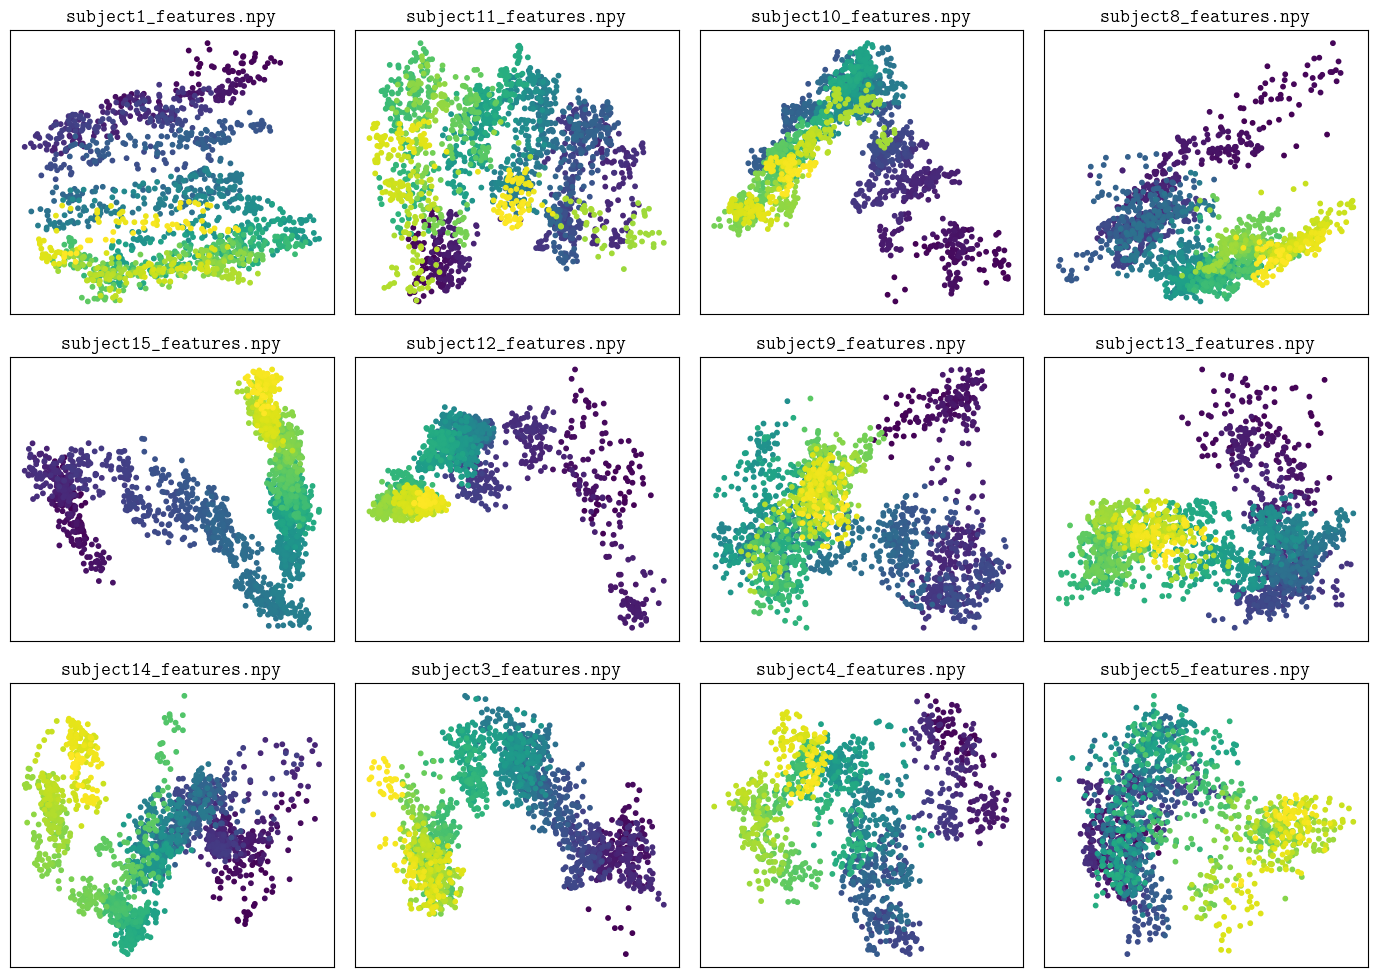

In [34]:
fig, ax = plt.subplots(3, 4, figsize=(14, 10))
cmap = plt.get_cmap('viridis')
for i, (subject, features_pca) in enumerate(pca.items()):
    row, col = i // 4, i % 4
    ax[row, col].scatter(features_pca[:, 0], features_pca[:, 1], c=np.arange(features_pca.shape[0]), cmap=cmap, s=10)
    ax[row, col].set_title(r"$\texttt{" + subject + r"}$")
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
plt.tight_layout()
plt.savefig(f'../figures/features_pca_{model_name}.pdf', bbox_inches='tight')
plt.show()

In [23]:
path_to_signals = '../processed/'
from prettytable import PrettyTable
rPPG_signals = {}
for file in os.listdir(path_to_signals):
    if file.endswith('_gt.npy'):
        subject = file.replace('_gt.npy', '')
        signal_path = os.path.join(path_to_signals, file)
        rPPG_signal = np.load(signal_path)
        rPPG_signals[subject] = rPPG_signal
table = PrettyTable()
table.field_names = ['Subject', 'Num. Samples', 'Mean (bpm)', 'Std. Dev. (bpm)']
for subject, rPPG_signal in rPPG_signals.items():
    table.add_row([subject, rPPG_signal.size, rPPG_signal.mean(), rPPG_signal.std()])
print(table)

+-----------+--------------+------------------------+--------------------+
|  Subject  | Num. Samples |       Mean (bpm)       |  Std. Dev. (bpm)   |
+-----------+--------------+------------------------+--------------------+
| subject10 |     2024     | -0.0036250900646739356 | 1.0066779805821335 |
|  subject3 |     1801     |  0.011070993977123814  | 1.023066408682712  |
|  subject1 |     1547     |  0.008577061396903691  | 1.025145564049015  |
| subject12 |     1989     |  0.004516271318903979  | 1.008327784252096  |
|  subject5 |     1550     | -0.0009977632806451682 | 0.9850117245863078 |
|  subject9 |     2016     | 0.0031586615771825336  | 0.9994246902597949 |
| subject14 |     1993     |  0.010790682949623685  | 0.9988473585368521 |
| subject11 |     2031     | -0.0009074363558493374 | 0.9924442324943342 |
| subject13 |     2018     | -0.0030525232508424216 | 1.0092469190907012 |
|  subject4 |     1368     |  0.03284474571059941   | 1.0165862002709836 |
|  subject8 |     2022   

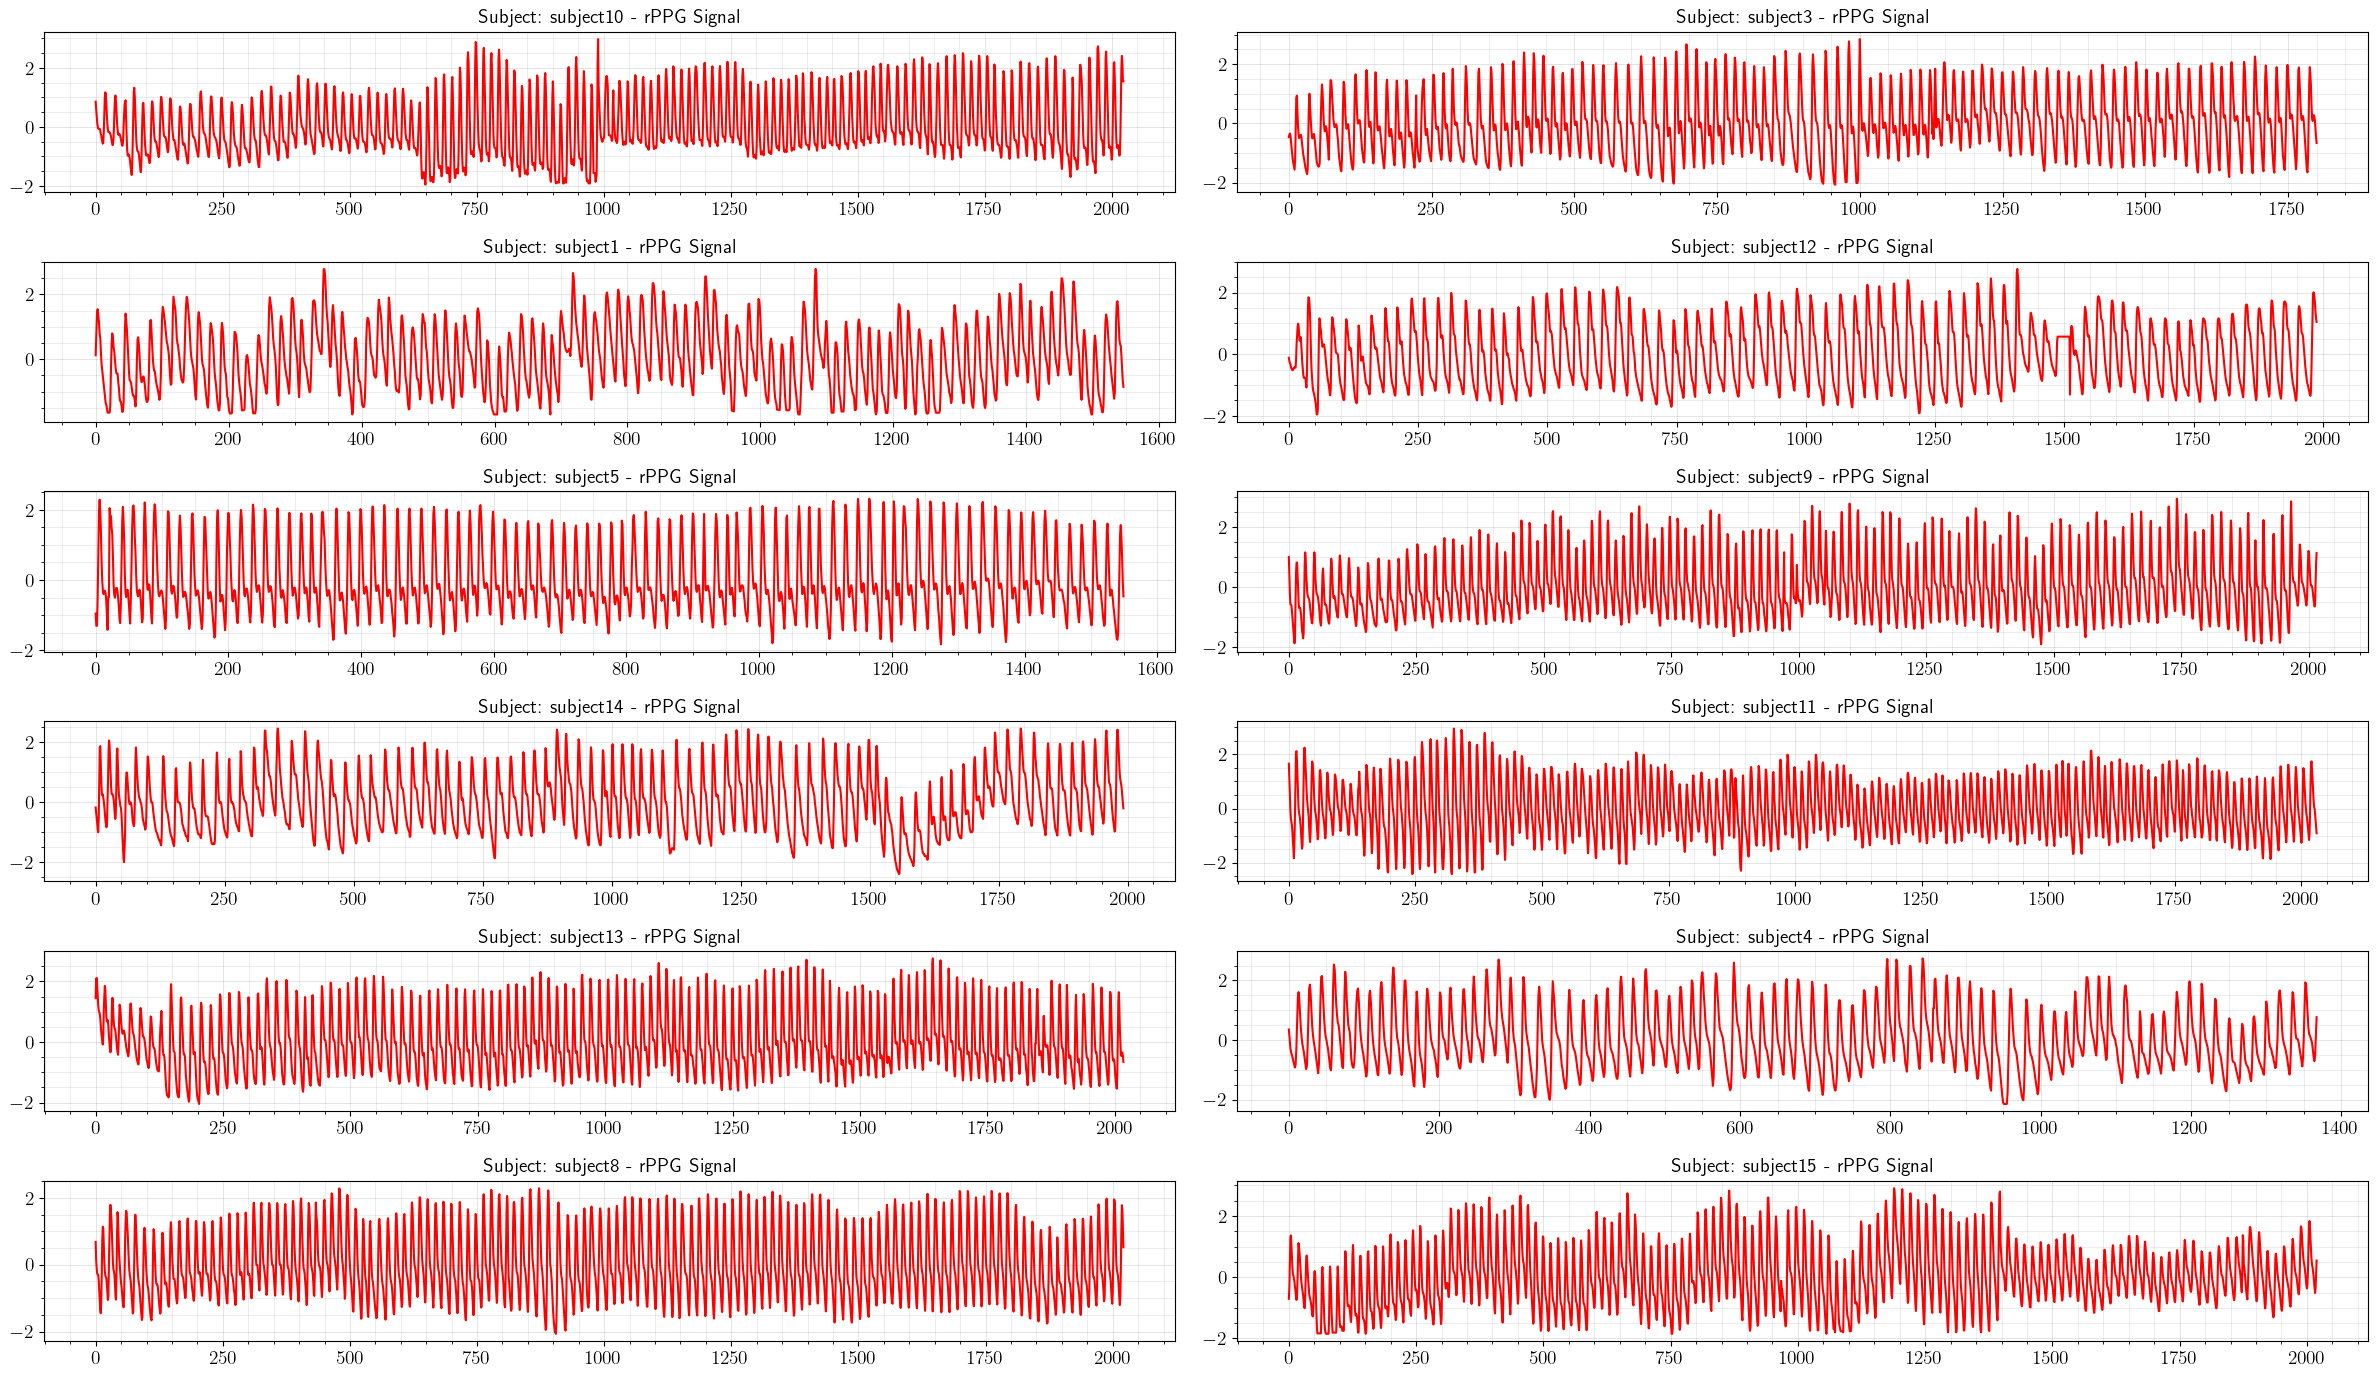

In [335]:
fig, ax = plt.subplots(6, 2, figsize=(24, 14))
for i, (subject, heart_rate) in enumerate(rPPG_signals.items()):
    row, col = i // 2, i % 2
    ax[row, col].plot(heart_rate, label=f"rPPG Signal", color='red', linewidth=1.5)
    ax[row, col].set_title(f"Subject: {subject} - rPPG Signal")
    ax[row, col].minorticks_on()
    ax[row, col].grid(which='major', linestyle='-', linewidth='0.5', color='grey', zorder=0, alpha=0.3)
    ax[row, col].grid(which='minor', linestyle='-', linewidth='0.5', color='gray', zorder=0, alpha=0.2)
plt.tight_layout()
plt.savefig(f'../figures/heart_rate.pdf', bbox_inches='tight')
plt.show()

In [4]:
path = '../processed/subject1_frames.npy'
frames = np.load(path)

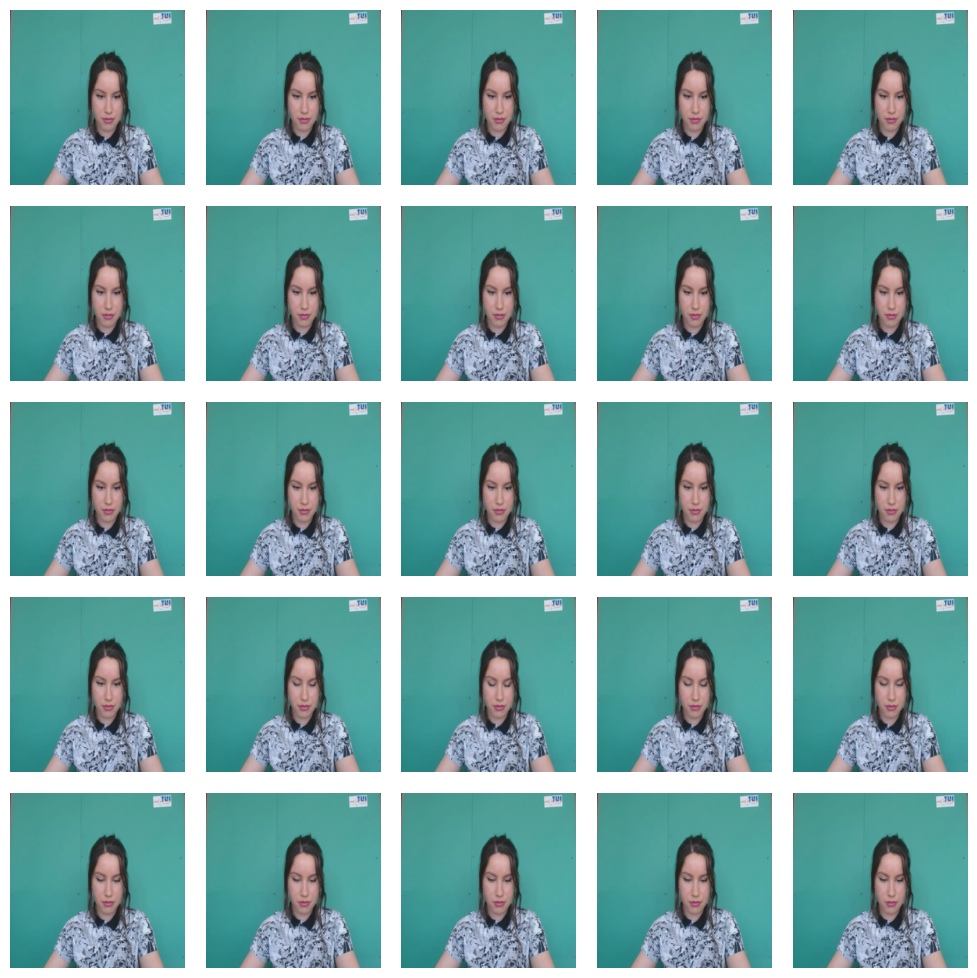

In [7]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    row, col = i // 5, i % 5
    ax[row, col].imshow(frames[i])
    ax[row, col].axis('off')
plt.tight_layout()
plt.savefig(f'../figures/frames.pdf', bbox_inches='tight')
plt.show()